<a href="https://colab.research.google.com/github/rohankodavalla/STM_Bus_Analysis/blob/main/montreal_bus_analysis_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What are we doing?
1.   Spatial Analysis - Identifying Busiest Stops
2.   Temporal Analysis - AM vs. PM Peak Demand
3.   Heatmaps of bus demand

In [26]:
!pip install geopandas >> /dev/null


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import io
import requests
import zipfile


In [28]:
# Load Montreal bus data

# URL of the ZIP file (GTFS data)
url = "https://www.stm.info/sites/default/files/gtfs/gtfs_stm.zip"
# Fetched from https://mobilitydatabase.org/feeds/mdb-2126

# Download the ZIP file
response = requests.get(url)
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Extract and read the required CSV files
        files = ["stops.txt", "stop_times.txt", "trips.txt"]
        data = {}  # Dictionary to store DataFrames

        for file in files:
            with z.open(file) as f:
                data[file] = pd.read_csv(f)

    # Assigning DataFrames
    stops = data["stops.txt"]
    stop_times = data["stop_times.txt"]
    trips = data["trips.txt"]

    # Display first few rows of each
    print("Stops Data:")
    print(stops.head())

    print("\nStop Times Data:")
    print(stop_times.head())

    print("\nTrips Data:")
    print(trips.head())

else:
    print("Failed to download the file:", response.status_code)



Stops Data:
        stop_id  stop_code          stop_name   stop_lat   stop_lon  \
0  STATION_M118      10118  STATION ANGRIGNON  45.446466 -73.603118   
1            43      10118  Station Angrignon  45.446466 -73.603118   
2         43-01      10118  Station Angrignon  45.446319 -73.603835   
3  STATION_M120      10120       STATION MONK  45.451158 -73.593242   
4            42      10120       Station Monk  45.451158 -73.593242   

                                            stop_url  location_type  \
0                                                NaN              1   
1  http://www.stm.info/fr/infos/reseaux/metro/ang...              0   
2                                                NaN              2   
3                                                NaN              1   
4    http://www.stm.info/fr/infos/reseaux/metro/monk              0   

  parent_station  wheelchair_boarding  
0            NaN                    1  
1   STATION_M118                    1  
2   STATION_M1

In [29]:
# ### 2. Data Preprocessing
# Focus on weekday morning/evening peaks

# Ensure consistent data types before merging
stops['stop_id'] = stops['stop_id'].astype(str)
stop_times['stop_id'] = stop_times['stop_id'].astype(str)
trips['trip_id'] = trips['trip_id'].astype(str)
stop_times['trip_id'] = stop_times['trip_id'].astype(str)


# %%
# Merge datasets
df = stop_times.merge(stops, on="stop_id").merge(trips, on="trip_id")

print(df.shape)




(9734422, 21)


In [30]:
print(df["service_id"].unique()[:10])  # Show first 10 unique service_id values


['24N-H50N000A-80-A' '24N-H50N000I-80-I' '24N-H50N000S-80-S'
 '24N-H50N000S-80-SV' '24N-H50N100F-80-F1' '24N-H50N200F-80-F2'
 '24N-H50N300F-80-F3' '24N-H50N400F-80-F4' '24N-H50NV10A-80-A'
 '24N-H50NV10I-80-I']


In [31]:
print(df["service_id"].value_counts().head(20))  # See most common service_id values


service_id
25J-H54J000S-80-S    109088
25J-H54JV00S-80-S    109088
24N-H54N000S-80-S    108872
24N-H54NV10S-80-S    108768
24N-H54NV20S-80-S    108768
25J-H56JV00S-80-S    105509
25J-H56J000S-80-S    105509
24N-H56N000S-80-S    105122
24N-H56NV20S-80-S    105122
24N-H56NV10S-81-S    105122
24N-H60N000S-81-S     97013
24N-H60NV20S-80-S     96469
24N-H60NV10S-80-S     96469
25J-H60J000S-80-S     96292
25J-H58J000S-81-S     95832
25J-H60JV00S-80-S     95748
24N-H58N000S-80-S     95110
25J-H58JV00S-81-S     94932
24N-H58NV20S-80-S     94210
24N-H58NV10S-80-S     94210
Name: count, dtype: int64


In [32]:
# Convert time columns to integers after handling potential errors during conversion
df["departure_time"] = pd.to_datetime(df["departure_time"], format="%H:%M:%S", errors="coerce").dt.hour

# Ensure 'departure_time' is in integer format
df["departure_time"] = df["departure_time"].astype("Int64")

# Now filter for peak hours (07:00-09:00 & 16:00-18:00)
peak_df = df[
    (df["departure_time"].between(7, 9, inclusive="both")) |
    (df["departure_time"].between(16, 18, inclusive="both"))
]

# Verify the shape of the filtered dataframe
print(peak_df.shape)
print(peak_df.head())


(3234244, 21)
       trip_id arrival_time  departure_time stop_id  stop_sequence  stop_code  \
129  280272141     07:01:00               7   56096              7      56096   
130  280272141     07:01:28               7   56092              8      56092   
131  280272141     07:02:09               7   56087              9      56087   
132  280272141     07:02:58               7   56084             10      56084   
133  280272141     07:04:04               7   56132             11      56132   

             stop_name   stop_lat   stop_lon  \
129  Graham / Rockland  45.520412 -73.629331   
130   Graham / Trenton  45.519875 -73.631147   
131    Graham / Simcoe  45.519101 -73.633759   
132    Graham / Dunrae  45.518192 -73.636836   
133    Graham / Regent  45.516947 -73.641045   

                                        stop_url  ...  parent_station  \
129  https://www.stm.info/fr/recherche#stq=56096  ...             NaN   
130  https://www.stm.info/fr/recherche#stq=56092  ...           

# Error was found prev, so this is  something I learnt, and changed code accordingly
*This error occurs because the stop_id column has different data types in stop_times and stops. One is int64, and the other is an object (likely a string).*
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-12-c3f32a8368fd> in <cell line: 0>()
      4 # %%
      5 # Merge datasets
----> 6 df = stop_times.merge(stops, on="stop_id").merge(trips, on="trip_id")
      7
      8 # Convert time columns, handling potential values over 24:00:00

3 frames
/usr/local/lib/python3.11/dist-packages/pandas/core/reshape/merge.py in _maybe_coerce_merge_keys(self)
   1506                     inferred_right in string_types and inferred_left not in string_types
   1507                 ):
-> 1508                     raise ValueError(msg)
   1509
   1510             # datetimelikes must match exactly

ValueError: You are trying to merge on int64 and object columns for key 'stop_id'. If you wish to proceed you should use pd.concat

In [33]:
print(df['service_id'].unique())  # See available service_id values


['24N-H50N000A-80-A' '24N-H50N000I-80-I' '24N-H50N000S-80-S'
 '24N-H50N000S-80-SV' '24N-H50N100F-80-F1' '24N-H50N200F-80-F2'
 '24N-H50N300F-80-F3' '24N-H50N400F-80-F4' '24N-H50NV10A-80-A'
 '24N-H50NV10I-80-I' '24N-H50NV10S-81-S' '24N-H50NV10S-81-SV'
 '24N-H50NV20A-80-A' '24N-H50NV20I-80-I' '24N-H50NV20S-80-S'
 '24N-H50NV20S-80-SV' '24N-H54N000A-80-A' '24N-H54N000I-80-I'
 '24N-H54N000S-80-S' '24N-H54N100F-80-F1' '24N-H54N200F-80-F2'
 '24N-H54N300F-80-F3' '24N-H54N400F-80-F4' '24N-H54NV10A-80-A'
 '24N-H54NV10I-80-I' '24N-H54NV10S-80-S' '24N-H54NV20A-80-A'
 '24N-H54NV20I-80-I' '24N-H54NV20S-80-S' '24N-H55N000A-80-A'
 '24N-H55N000I-80-I' '24N-H55N000S-80-S' '24N-H55N000S-80-SV'
 '24N-H55N100F-80-F1' '24N-H55N200F-80-F2' '24N-H55N300F-80-F3'
 '24N-H55N400F-80-F4' '24N-H55NV10A-80-A' '24N-H55NV10I-80-I'
 '24N-H55NV10S-83-S' '24N-H55NV10S-83-SV' '24N-H55NV20A-80-A'
 '24N-H55NV20I-80-I' '24N-H55NV20S-80-S' '24N-H55NV20S-80-SV'
 '24N-H56N000A-80-A' '24N-H56N000I-80-I' '24N-H56N000S-80-S'
 '24N-

# 1. Spatial Analysis - Identifying Busiest Stops // filtering trips based on peak departure times (07:00-09:00 & 16:00-18:00)

In [34]:
# ### 3. Spatial Analysis
# Identify busiest stops during peaks

# %%
# Aggregate departures by stop
stop_activity = (
    peak_df.groupby(["stop_id", "stop_name", "stop_lat", "stop_lon"])
    .size()
    .reset_index(name="departures")
    .sort_values("departures", ascending=False)
)

# Top 10 busiest stops
print("Busiest Transit Hubs:")
display(stop_activity.head(10).style.background_gradient(cmap="Reds"))

Busiest Transit Hubs:


,stop_id,stop_name,stop_lat,stop_lon,departures
28,36,Station Lionel-Groulx,45.482509,-73.580180,2850
3619,54127,Station Henri-Bourassa,45.556117,-73.667282,2176
2897,53287,Sherbrooke / Saint-Donat,45.601134,-73.532423,1940
2899,53289,Sherbrooke / Saint-Donat,45.600830,-73.532279,1840
4419,55073,Henri-Bourassa / Pelletier,45.598390,-73.640215,1828
7902,60633,Angrignon / face aux tours Angrignon,45.446925,-73.607584,1796
4906,55594,Côte-Vertu / Leduc,45.510803,-73.687253,1721
643,50747,Sherbrooke / Patricia,45.455402,-73.641252,1703
236,50303,Station Henri-Bourassa,45.554262,-73.668563,1696
281,50351,Henri-Bourassa / Christophe-Colomb,45.562444,-73.662481,1640


# Percentage of Stops Handling Peak Departures

In [35]:
# Calculate total departures in peak hours
total_peak_departures = peak_df.shape[0]

# Calculate the percentage of total departures handled by top stops
top_stops = stop_activity.head(10)
top_stop_departures = top_stops['departures'].sum()
percent_top_stop_departures = (top_stop_departures / total_peak_departures) * 100

print(f"Top 10 stops handle {percent_top_stop_departures:.2f}% of peak departures")


Top 10 stops handle 0.59% of peak departures


# 2. Temporal Analysis - AM vs. PM Peak Demand

PM Peak vs. AM Peak.
If the PM peak has more departures than the AM peak, extending the PM peak service window can help balance congestion.

<ipython-input-36-fea21b662d08>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=peak_df, x='departure_time', y='departure_time',
<ipython-input-36-fea21b662d08>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peak_df, x='departure_time', y='departure_time',


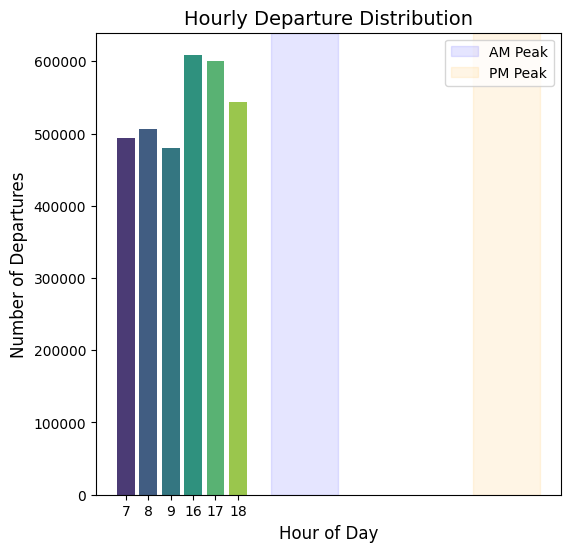

In [36]:
# ### 4. Temporal Analysis
# Compare AM vs PM peak demand

# %%
plt.figure(figsize=(6,6))
sns.barplot(data=peak_df, x='departure_time', y='departure_time',
            estimator='count', ci=None, palette='viridis')
plt.title("Hourly Departure Distribution", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Departures", fontsize=12)
plt.axvspan(6.5, 9.5, alpha=0.1, color='blue', label='AM Peak')
plt.axvspan(15.5, 18.5, alpha=0.1, color='orange', label='PM Peak')
plt.legend()
plt.show()

In [37]:
# Calculate AM and PM peak departures
am_peak = peak_df[peak_df['departure_time'].between(7, 9, inclusive="both")]
pm_peak = peak_df[peak_df['departure_time'].between(16, 18, inclusive="both")]

am_departures = am_peak.shape[0]
pm_departures = pm_peak.shape[0]

# Compare the PM peak departures to AM peak
pm_am_difference = (pm_departures - am_departures) / am_departures * 100

print(f"PM peak has {pm_am_difference:.2f}% more departures than AM peak")

# If PM peak has more departures, suggest extending service window
if pm_am_difference > 0:
    print(f"Extend PM peak service window by {int(pm_am_difference)} minutes.")



PM peak has 18.38% more departures than AM peak
Extend PM peak service window by 18 minutes.


# 3. Heatmaps of bus demand

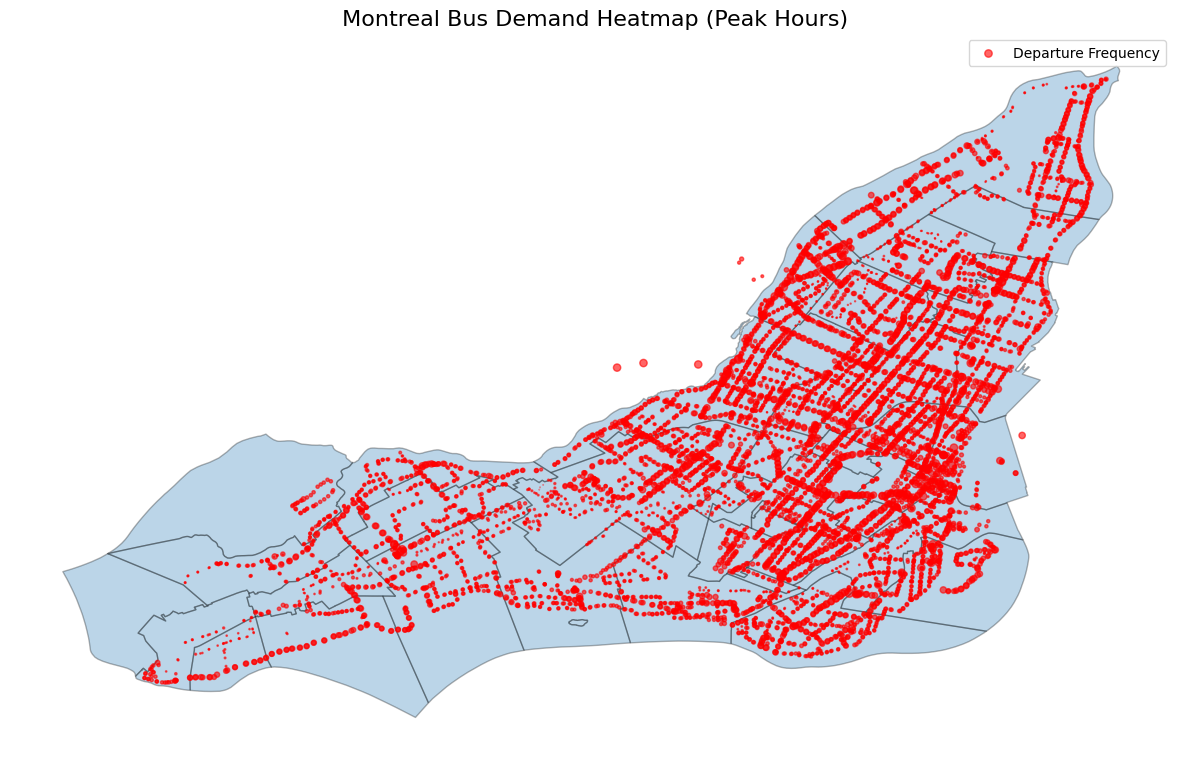

In [38]:
# ### 5. Geographic Visualization
# Map demand hotspots

# %%
# Convert to GeoDataFrame
geometry = gpd.points_from_xy(stop_activity.stop_lon, stop_activity.stop_lat)
gdf = gpd.GeoDataFrame(stop_activity, geometry=geometry)

# Load Montreal boroughs
montreal = gpd.read_file("https://donnees.montreal.ca/en/dataset/limites-administratives-agglomeration/resource/e18bfd07-edc8-4ce8-8a5a-3b617662a794/download")

# Create figure
fig, ax = plt.subplots(figsize=(15,10))
montreal.plot(ax=ax, alpha=0.3, edgecolor='black')
gdf.plot(ax=ax, markersize=gdf['departures']/50,
         alpha=0.6, color='red', label='Departure Frequency')
plt.title(" Montreal Bus Demand Heatmap (Peak Hours)", fontsize=16)
plt.axis('off')
plt.legend()
plt.show()

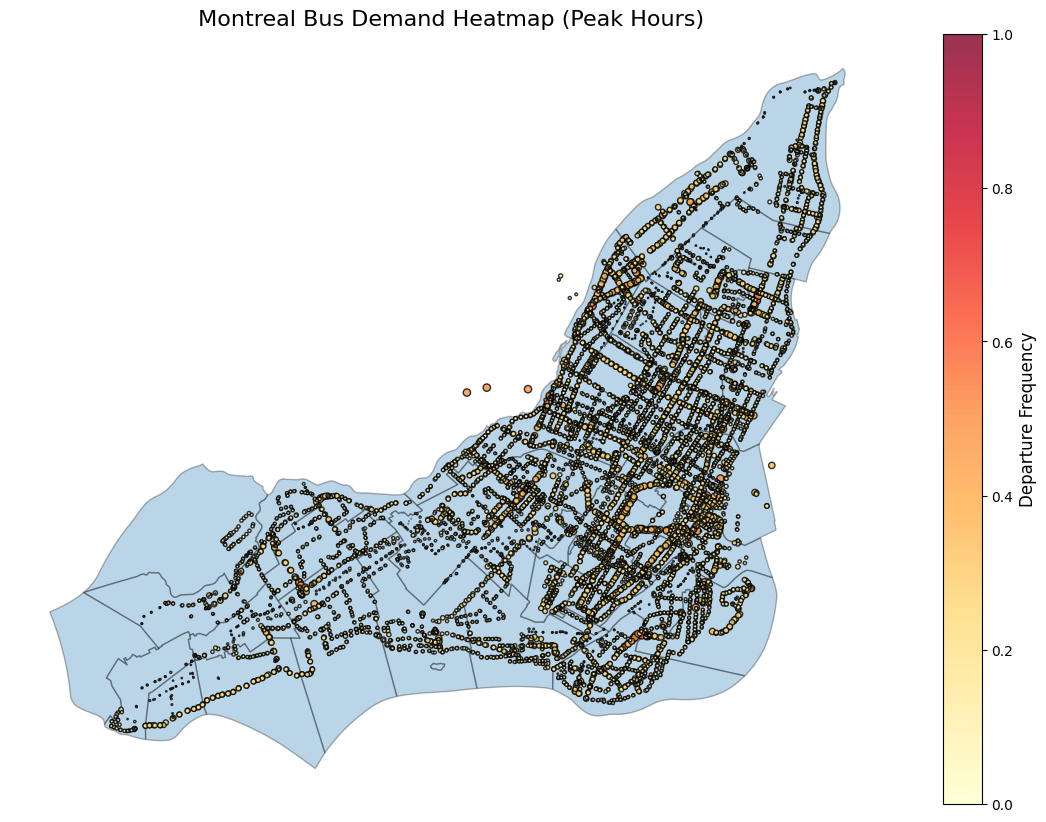

In [39]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

# Convert to GeoDataFrame
geometry = gpd.points_from_xy(stop_activity.stop_lon, stop_activity.stop_lat)
gdf = gpd.GeoDataFrame(stop_activity, geometry=geometry)

# Load Montreal boroughs
montreal = gpd.read_file("https://donnees.montreal.ca/en/dataset/limites-administratives-agglomeration/resource/e18bfd07-edc8-4ce8-8a5a-3b617662a794/download")

# Normalize departure values for colormap
min_dep, max_dep = gdf['departures'].min(), gdf['departures'].max()
gdf['normalized_dep'] = (gdf['departures'] - min_dep) / (max_dep - min_dep)

# Create figure
fig, ax = plt.subplots(figsize=(15, 10))
montreal.plot(ax=ax, alpha=0.3, edgecolor='black')

# Scatter plot with color gradient
sc = ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    s=gdf['departures'] / 50,  # Adjust size based on departures
    c=gdf['normalized_dep'],  # Use normalized departures for color mapping
    cmap='YlOrRd',  # Yellow → Orange → Red
    alpha=0.8, edgecolor='black'
)

plt.title(" Montreal Bus Demand Heatmap (Peak Hours)", fontsize=16)
plt.axis('off')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Departure Frequency', fontsize=12)

plt.show()


In [42]:
import folium
import pandas as pd
from folium.plugins import HeatMap

# Create a base map centered on Montreal
m = folium.Map(location=[45.5017, -73.5673], zoom_start=12)

# Prepare data for HeatMap (latitude, longitude, weight)
heat_data = list(zip(gdf.stop_lat, gdf.stop_lon, gdf.departures))

# Add HeatMap layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=14).add_to(m)

# Display map
m


#Ideas >>
# Find the busiest hours of the week(but need historical data, limited to GTFS) and Top 10 Busiest Stops - sorted day wise
# why? to determine if a particular bus frequency/bus route can be relaxed on maybe a weekend or holiday >> saving operational costs
